# Self-Supervised Learning with Triplet Loss for Blood Cell Images

In [120]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os

# 1. Data

In [121]:
class BloodDataset(Dataset):
    """
    Custom dataset for blood cell images (self-supervised learning)
    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = datasets.ImageFolder(root, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, _ = self.data[idx]  # Ignore the label
        return image

In [122]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = BloodDataset('data/images/TRAIN', transform=transform)
test_dataset = BloodDataset('data/images/TEST', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [123]:
def imshow(img, label=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()
def show_batch(batch):
    images = batch
    grid = torchvision.utils.make_grid(images)
    imshow(grid)

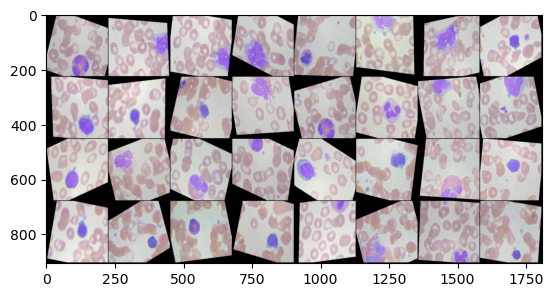

In [124]:
batch = next(iter(train_loader))
show_batch(batch)

# 2. Model

In [125]:
from model import BloodNet
from loss import TripletLoss
from utils import mine_hard_negatives

In [126]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: mps


In [127]:
model = BloodNet().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Anchor:


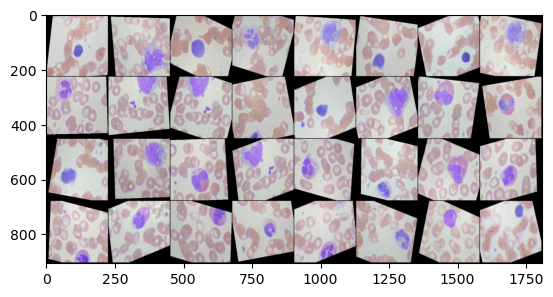

Positive:


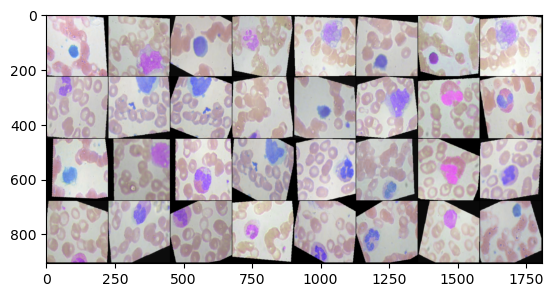

Negative:


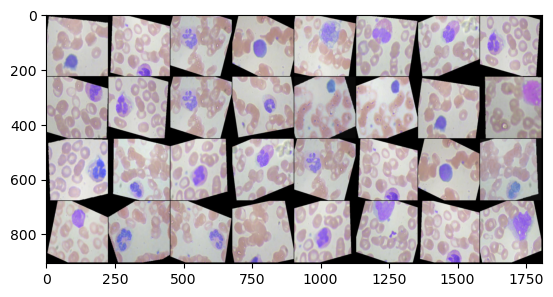

In [128]:
# Find some hard-negative examples on the batch
model.eval()
with torch.no_grad():
    batch = next(iter(train_loader))
    batch = batch.to(device)
    anchor, positive, negative = mine_hard_negatives(model, batch)
    print('Anchor:')
    show_batch(anchor)
    print('Positive:')
    show_batch(positive)
    print('Negative:')
    show_batch(negative)

# 3. Training

In [129]:
# Training loop
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc='Training')):
        batch = batch.to(device)
        optimizer.zero_grad()
        anchor, positives, hard_negatives = mine_hard_negatives(model, batch)
        
        # Forward pass to get embeddings for anchor
        anchor_embeddings = model(anchor)
        
        # Forward pass to get embeddings for positive examples
        positive_embeddings = model(positives)
        
        # Forward pass to get embeddings for hard negatives
        negative_embeddings = model(hard_negatives)
        
        # Compute loss
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [130]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    loss = train(model, criterion, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
    
    # Save the model
    if os.path.exists('models') is False:
        os.makedirs('models')
    torch.save(model.state_dict(), f'models/bloodnet-{epoch+1}.pth')

Training: 100%|██████████| 312/312 [02:18<00:00,  2.25it/s]


Epoch 1/10, Loss: 0.17981868208600923


Training: 100%|██████████| 312/312 [02:16<00:00,  2.29it/s]


Epoch 2/10, Loss: 0.10541815393849109


Training: 100%|██████████| 312/312 [02:15<00:00,  2.30it/s]


Epoch 3/10, Loss: 0.06456862701676212


Training: 100%|██████████| 312/312 [02:17<00:00,  2.28it/s]


Epoch 4/10, Loss: 0.044706772950191334


Training: 100%|██████████| 312/312 [02:18<00:00,  2.25it/s]


Epoch 5/10, Loss: 0.03547920709332594


Training: 100%|██████████| 312/312 [02:19<00:00,  2.24it/s]


Epoch 6/10, Loss: 0.03348804680326094


Training: 100%|██████████| 312/312 [02:18<00:00,  2.26it/s]


Epoch 7/10, Loss: 0.031794343318324536


Training: 100%|██████████| 312/312 [02:18<00:00,  2.26it/s]


Epoch 8/10, Loss: 0.028055291064680576


Training: 100%|██████████| 312/312 [02:19<00:00,  2.24it/s]


Epoch 9/10, Loss: 0.031231016546744518


Training: 100%|██████████| 312/312 [02:16<00:00,  2.28it/s]

Epoch 10/10, Loss: 0.025279294087503772


# 4. Testing

In [136]:
from sklearn.manifold import TSNE

In [137]:
# Test the model
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(test_loader, total=len(test_loader), desc='Testing'):
        batch = batch.to(device)
        embeddings.append(model(batch).cpu().numpy())
        
embeddings = np.concatenate(embeddings)

Testing: 100%|██████████| 78/78 [00:05<00:00, 13.42it/s]


In [138]:
# Apply K-means clustering to the embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
pseudo_labels = kmeans.fit(embeddings)

In [139]:
# Visualize the embeddings using t-SNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(embeddings)

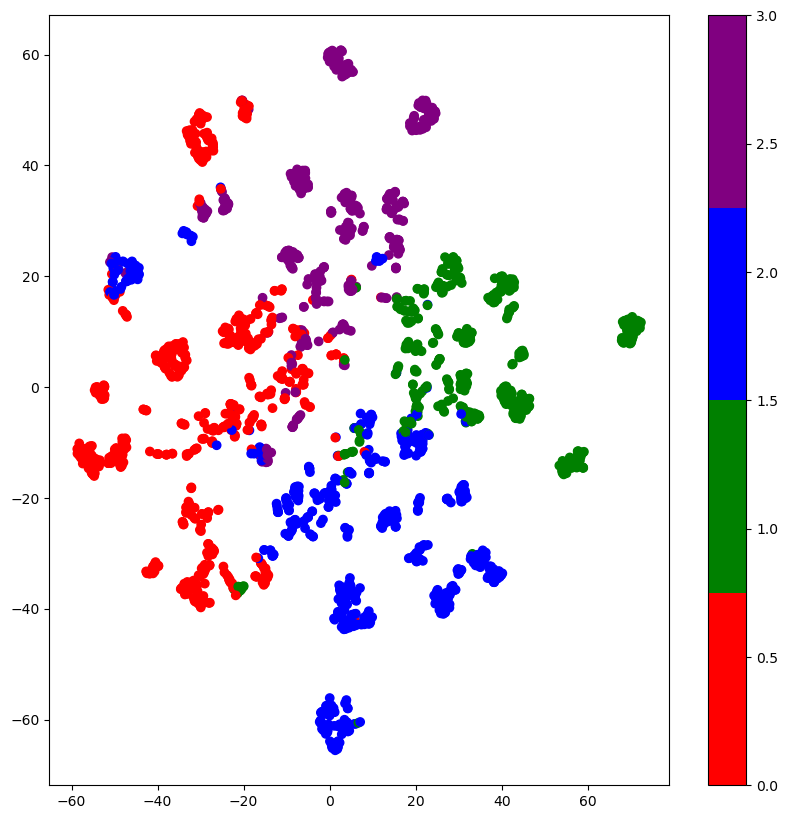

In [140]:
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple']
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pseudo_labels.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()
plt.show()